In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Cartesian mesh

For this assignment, you are required to generate a Cartesian mesh and map particle positions onto the grid using two techniques:
- Nearest-Neighbour (NN)
- Cloud-in-Cell (CIC).

#### Then reconstruct the density field for both methods and compare the resulting densities between NN and CIC.

#### Finally, compute the radial density profile directly from the particle positions and compare it with the densities obtained from both methods, discussing any observed differences.

---
The columns are x, y, z.

cloud_full.ascii is the same but also contains the density (for them to check) and an internal energy (x, y, z, rho, u).

The mass of the particles should be chosen such that the full system amounts to M = 1.

In [3]:
def load_stars() -> np.ndarray:
    stars = np.loadtxt("cloud_positions.ascii", delimiter=" ")
    print(f"Loaded {stars.shape[0]} stars")

    return stars

In [4]:
def show_star_information(stars: np.ndarray):
    # show stars in a 3d plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(stars[:,0], stars[:,1], stars[:,2], cmap='viridis', c=range(len(stars)))
    plt.show()
    # show information about the stars
    print("Boundaries of the cloud:")
    print(f"X: {np.min(stars[:,0])} -- {np.max(stars[:,0])}")
    print(f"Y: {np.min(stars[:,1])} -- {np.max(stars[:,1])}")
    print(f"Z: {np.min(stars[:,2])} -- {np.max(stars[:,2])}")

Loaded 65494 stars


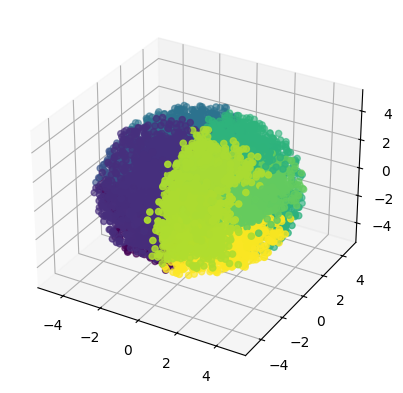

Boundaries of the cloud:
X: -4.682902329484604 -- 4.766703221473182
Y: -4.726203586592766 -- 4.705220728447327
Z: -4.752454756889135 -- 4.77485540190913


In [5]:
stars = load_stars()
show_star_information(stars)

In [6]:
def create_mesh(n_cell_axis: int) -> tuple[np.ndarray, np.ndarray]:
    axis = np.linspace(-5, 5, n_cell_axis)
    mesh_grid = np.meshgrid(axis, axis, axis)
    mesh = np.zeros_like(mesh_grid[0])
    return mesh, axis


def fill_mesh(mesh: np.ndarray, axis, stars: np.ndarray, shape_function: callable):
    # fills the mesh in place
    for star in stars:
        # spread the star onto cells through the shape function
        ijks, weights = shape_function(star, axis)
        for ijk, weight in zip(ijks, weights):
            mesh[ijk[0], ijk[1], ijk[2]] += weight


In [7]:
## Helper functions for star mapping

def star_to_cells_nn(star, axis):
    # find the single cell that contains the star
    ijk = np.digitize(star, axis) - 1
    # the weight is obviously 1
    return [ijk], [1]


def star_to_cells_cic(star, axis, width):
    # create a virtual cell around the star
    cell_bounds = [
        star + np.array([1, 0, 0]) * width,
        star + np.array([-1, 0, 0]) * width,
        star + np.array([1, 1, 0]) * width,
        star + np.array([-1, -1, 0]) * width,
        star + np.array([1, 1, 1]) * width,
        star + np.array([-1, -1, 1]) * width,
        star + np.array([1, 1, -1]) * width,
        star + np.array([-1, -1, -1]) * width,
    ]
    # find all the cells that intersect with the virtual cell
    ijks = []
    weights = []
    for b in cell_bounds:
        w = np.linalg.norm(star - b)
        ijk = np.digitize(b, axis) - 1
        # print(f"b: {b}, ijk: {ijk}")
        ijks.append(ijk)
        weights.append(w)
    # ensure that the weights sum to 1
    weights = np.array(weights)
    weights /= np.sum(weights)
    return ijks, weights


In [8]:
## Helper functions for mesh plotting
def show_mesh_information(mesh, name):
    print(f"Mesh information for {name}")
    print(f"Total mapped mass: {np.sum(mesh):.0f}")
    print(f"Max cell value: {np.max(mesh)}")
    print(f"Min cell value: {np.min(mesh)}")
    print(f"Mean cell value: {np.mean(mesh)}")
    plot_3d(mesh, name)
    plot_2d(mesh, name)


def plot_3d(mesh, name):
    fig = plt.figure()
    fig.suptitle(name)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*np.where(mesh), c=mesh[np.where(mesh)], cmap='viridis')
    plt.show()


def plot_2d(mesh, name):
    fig = plt.figure()
    fig.suptitle(name)
    axs = fig.subplots(1, 3)
    axs[0].imshow(np.sum(mesh, axis=0))
    axs[0].set_title("Flattened in x")
    axs[1].imshow(np.sum(mesh, axis=1))
    axs[1].set_title("Flattened in y")
    axs[2].imshow(np.sum(mesh, axis=2))
    axs[2].set_title("Flattened in z")
    plt.show()

In [9]:
mesh_size = 150


mesh_nn, axis = create_mesh(mesh_size)
fill_mesh(mesh_nn, axis, stars, star_to_cells_nn)


mesh_cic, axis = create_mesh(mesh_size)
cell_width = (axis[1] - axis[0]) / 2
fill_func = lambda star, axis: star_to_cells_cic(star, axis, cell_width)
fill_mesh(mesh_cic, axis, stars, fill_func)


Mesh information for Nearest Neighbour
Total mapped mass: 65494
Max cell value: 4.0
Min cell value: 0.0
Mean cell value: 0.01940562962962963


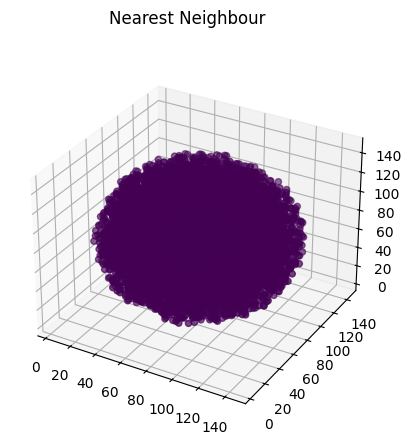

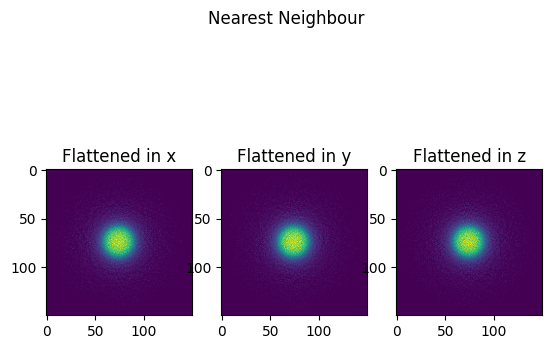

Mesh information for Cloud in Cell
Total mapped mass: 65494
Max cell value: 2.5124410112017768
Min cell value: 0.0
Mean cell value: 0.019405629629629623


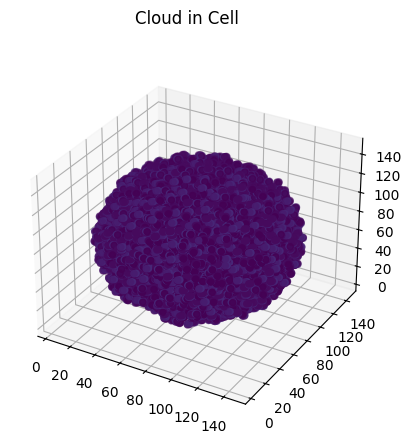

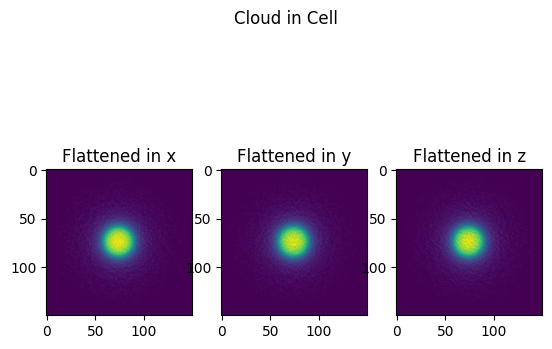

In [10]:
show_mesh_information(mesh_nn, "Nearest Neighbour")
show_mesh_information(mesh_cic, "Cloud in Cell")

### Density profile

Bin 0.0 -- 1.3121597027036949: 9.0
Bin 1.3121597027036949 -- 2.6243194054073897: 104.0
Bin 2.6243194054073897 -- 3.936479108111085: 233.0
Bin 3.936479108111085 -- 5.2486388108147795: 515.0
Bin 5.2486388108147795 -- 6.560798513518474: 848.0
Bin 6.560798513518474 -- 7.87295821622217: 1090.0
Bin 7.87295821622217 -- 9.185117918925863: 1755.0
Bin 9.185117918925863 -- 10.497277621629559: 2372.0
Bin 10.497277621629559 -- 11.809437324333254: 2775.0
Bin 11.809437324333254 -- 13.121597027036948: 3557.0
Bin 13.121597027036948 -- 14.433756729740644: 4191.0
Bin 14.433756729740644 -- 15.74591643244434: 4528.0
Bin 15.74591643244434 -- 17.058076135148035: 4341.0
Bin 17.058076135148035 -- 18.370235837851727: 3691.0
Bin 18.370235837851727 -- 19.682395540555422: 3268.0
Bin 19.682395540555422 -- 20.994555243259118: 2771.0
Bin 20.994555243259118 -- 22.306714945962813: 2537.0
Bin 22.306714945962813 -- 23.61887464866651: 2150.0
Bin 23.61887464866651 -- 24.9310343513702: 1930.0
Bin 24.9310343513702 -- 26.2431

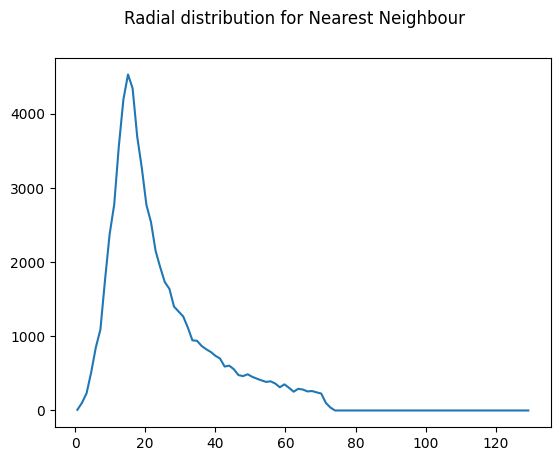

In [12]:

def radial_distributions(mesh, nbins=100):
    center = np.array(mesh.shape) // 2
    indices = np.indices(mesh.shape)
    distances_to_center = np.linalg.norm(indices - center[:, None, None, None], axis=0)
    max_distance = np.max(distances_to_center)
    distances = np.linspace(0, max_distance, nbins)
    for i in range(len(distances) - 1):
        # create a radial shell between r_inner and r_outer
        r_inner = distances[i]
        r_outer = distances[i+1]
        shell = np.zeros_like(mesh, dtype=bool)
        shell[(distances_to_center >= r_inner) & (distances_to_center < r_outer)] = True
        shell_mass = np.sum(mesh[shell])
        shell_volume = 4/3 * np.pi * (r_outer**3 - r_inner**3)
        yield r_inner, r_outer, shell_mass/shell_volume

def plot_distributions(mesh, name):
    fig = plt.figure()
    fig.suptitle(f"Radial distribution for {name}")
    bins = []
    values = []
    for bin_low, bin_high, value in radial_distributions(mesh):
        print(f"Bin {bin_low} -- {bin_high}: {value}")
        bins.append(bin_low + (bin_high - bin_low) / 2)
        values.append(value)
    plt.plot(bins, values, label=name)
    plt.show()

plot_distributions(mesh_nn, "Nearest Neighbour")    
